# XAI DEV Playground

In [1]:
import sys
import os

# Add the path to the parent module
sys.path.append(os.path.abspath('../..'))

In [24]:
from deeppy.models import Network
from deeppy.models import LayerGenerator, Optimizer, Scheduler
from deeppy.data import DataGetter
from deeppy import LearnFrame
from assets.tutorial_utils import *

import torch

from typing import List, Tuple
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import matplotlib.pyplot as plt

In [4]:
data = get_toy_dataset()
X,y = data.train_data()

In [6]:
class MixedActivation(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, input):
        l = input.shape[1]
        i1,i2 = input[:,:l], input[:,l:]
        return torch.cat((torch.relu(i1), torch.sigmoid(i2)),dim=1)
        
class Electrode(nn.Module):
    def __init__(self):
        super().__init__()
        self.e_act = None
        self.e_grad = None
        self.V = None
        
    def forward(self, X):
        print("A")
        if self.V is not None:
            X = self.V
        self.e_act = X
        return X
        
    def backwards(self,X):
        self.e_grad = X
        return X

    def voltage(self,X):
        self.V = X

In [85]:
arch_params = {
    "layers":[2,64,64,1],
    "blocks":[nn.Linear, nn.Dropout, nn.ReLU],
    "block_args":[{}, {"p":0.2}],
    "out_act":nn.Identity,
    "out_params":{},
    "weight_init":"uniform",
}



Optimizer_params = {
    "optimizer":optim.AdamW,
    "optimizer_args":{"lr":1e-4, "amsgrad" : True},
}

Network_params = {
"arch_params":[arch_params],
"decoder_params":None,
"task":'reg',
"optimizer_params":Optimizer_params,
}

net = Network(**Network_params)


print(f"input : {Xd.shape}")
out = net(Xd)
nn.MSELoss()(out,yd).backward()
print(f"output : {out.shape}")

input : torch.Size([128, 2])
output : torch.Size([128, 1])


In [86]:
#pop, append, extend, insert

# Forward overriding for voltage
# Hooks for tracking

In [122]:



class Xai():
    def __init__(self,model):
        self.model = model
    
    def get_mesh(self,ranges : List[Tuple[float, float]], resolutions : List[int]) -> torch.tensor:
        spaces = [torch.linspace(*rng,steps=res) for rng,res in zip(ranges,resolutions)]
        mesh = torch.meshgrid(*spaces)
        return torch.stack(mesh) , torch.stack(spaces)
    def plot_state_space(self, ranges = [], dims = [], resolution = 100):
        for rng in ranges:
            pass
xai = Xai(net)

In [123]:
mesh, space = xai.get_mesh([(0,1),(0,1)],[10,10])

/home/boz/anaconda3/envs/deeppy/lib/python3.13/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [124]:
mesh.shape

torch.Size([2, 10, 10])

In [125]:
for n in net.model:
    print(n)
    print(list(n.parameters()))

Linear(in_features=2, out_features=64, bias=True)
[Parameter containing:
tensor([[ 0.6130,  0.4974],
        [-0.3212, -0.0713],
        [-0.5957, -0.4393],
        [-0.6514,  0.6838],
        [-0.2936, -0.6757],
        [ 0.6695, -0.0465],
        [-0.3235, -0.1808],
        [-0.1886,  0.2384],
        [ 0.2272, -0.6958],
        [ 0.5838, -0.3522],
        [ 0.3873,  0.3941],
        [ 0.3931,  0.5279],
        [ 0.0091,  0.5793],
        [-0.1042, -0.0242],
        [-0.5907,  0.2545],
        [-0.2672,  0.4951],
        [ 0.0951, -0.3450],
        [ 0.3026, -0.0450],
        [-0.4278, -0.5064],
        [ 0.2293, -0.2166],
        [ 0.2670, -0.5028],
        [-0.2102, -0.6855],
        [ 0.2936,  0.2021],
        [-0.1540,  0.5160],
        [-0.6024, -0.4414],
        [-0.3334, -0.1065],
        [-0.1925, -0.5652],
        [ 0.5349, -0.2677],
        [-0.1857,  0.2198],
        [-0.3129, -0.5284],
        [-0.1391,  0.5883],
        [-0.4906,  0.2162],
        [ 0.4989, -0.0407],
   

In [114]:
def weight_matrix_to_plot(W,ax, layer_ix, input_ixes = None, output_ixes = None):
    #out -> rows
    cmap = cm.coolwarm
    W = W.cpu()
    
    if output_ixes is not None:
        W = W[output_ixes]
    if input_ixes is not None:
        W = W[:,input_ixes]

    H, W_ = W.shape
    W_prod = (H * W_)
    W = W.view(-1)
    
    max_val, min_val = torch.max(W), torch.min(W)
    
    mag = torch.abs(W)
    mag = mag / torch.max(mag)
    
    sign = torch.sign(W)

    line_widths = mag
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    colors = cmap(norm(sign*mag))
    
    
    
    Xs = torch.tensor((layer_ix, layer_ix + 1)).tile(W_prod,1)

    m1, m2 = torch.meshgrid(torch.arange(H), torch.arange(W_), indexing='ij')
    Ys = torch.stack([m1, m2], dim=-1).view(-1, 2)

    print(Ys.shape)
    print(Xs.shape)
    for x,y,c,l in zip(Xs,Ys,colors,line_widths):
        ax.plot(x,y,color=c,linewidth = l)

    
def linear_layer_to_plot(layer, ax, layer_ix = 0, permute = False):
    layer = layer.cpu()
    if permute:
        layer, p_ixes = torch.sort(layer, dim=0)
    else:
        p_ixes = torch.arange(len(layer))
    
    X = torch.full(layer.shape, layer_ix)
    Y = torch.arange(layer.shape[0])
    C = layer

    ax.scatter(X,Y, c=C, s=80, cmap = "coolwarm", edgecolors= ["black"], linewidths=1)
    return p_ixes

In [127]:
W = torch.rand(64,64) * 2 - 1
l1 = torch.rand(64,1)
l2 = torch.rand(64,1)

torch.Size([4096, 2])
torch.Size([4096, 2])


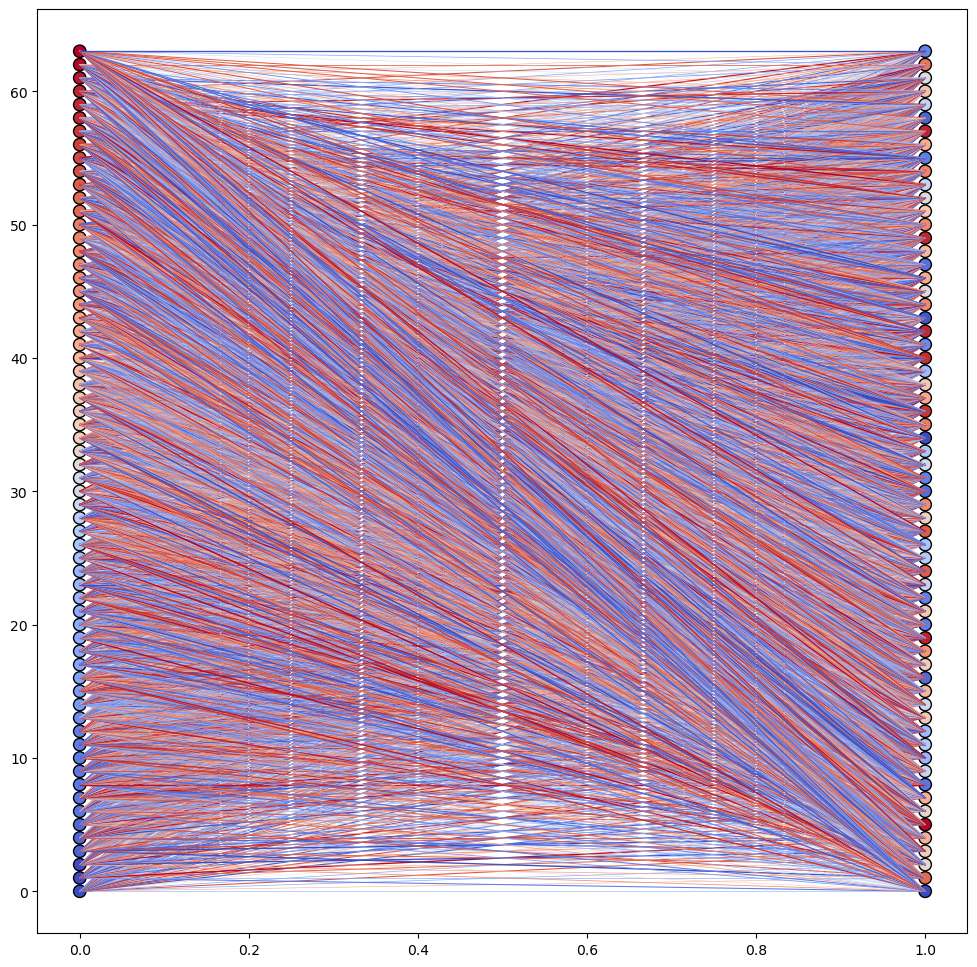

In [129]:

fig, ax = plt.subplots(1, figsize=(12,12))

p_ix = linear_layer_to_plot(l1,ax, layer_ix=0, permute= True)
p_ix = linear_layer_to_plot(l2, ax, layer_ix = 1)
weight_matrix_to_plot(W,ax,0)

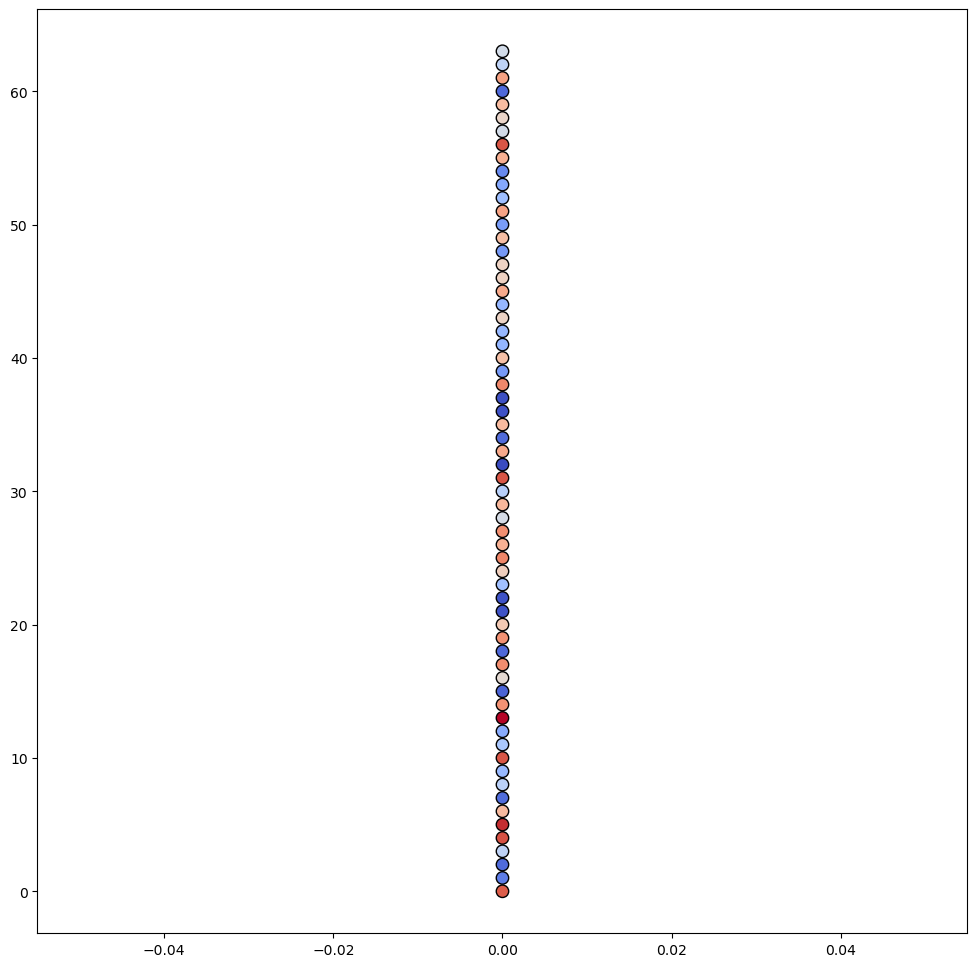

In [30]:
fig, ax = plt.subplots(1, figsize=(12,12))
p_ix = linear_layer_to_plot(A, ax)
plt.show()

In [5]:
from deeppy import plot_scheduler

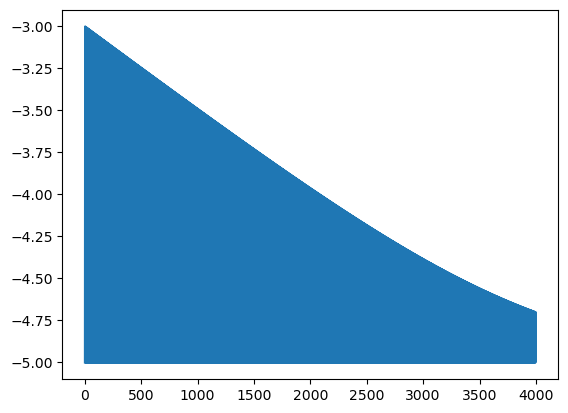

In [35]:
lrs = plot_scheduler(optim.lr_scheduler.CyclicLR, params = {
    "base_lr":1e-5,
    "max_lr":1e-3,
    "step_size_up":2,
    "scale_fn" : lambda x: 0.01**(x/1000),
    "scale_mode":"cycle"
}, step = 4000)

plt.plot(np.log10(lrs))